# Simulation 4X
In this notebook we run a few sensitivity studies starting from the results in *Simulation4.ipynb*.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has up to 4 visible files and up to 2 hidden files, and 4 potential vulnerable parameter that may be used against the vulnerable file.

Setting a random seed

In [2]:
np.random.seed(100)

### Random server
We define a simple function to instantiate random servers.

In [3]:
from networkx.generators.classic import complete_graph

def random_server():
    n_visiblefiles = np.random.randint(2,const.N_VISIBLEFILES+1)
    n_hiddenfiles = np.random.randint(0,const.N_HIDDENFILES+1)
    n_totalfiles = n_visiblefiles+n_hiddenfiles
    
    visiblefilesystem = complete_graph(n_visiblefiles)
    filesystem = visiblefilesystem.copy()
    for h in range(n_hiddenfiles):
        filesystem.add_edge(np.random.choice(n_visiblefiles),n_visiblefiles+h)
        
    vulnfile = np.random.choice(n_totalfiles)
    vulnparam = np.random.choice(const.N_VULNPARAMS)+1
    
    return srv.Server(visiblefilesystem, filesystem, vulnfile, vulnparam)

## Simulation 4X

We train $20$ agents for $10^5$ episodes, and test them on $100$ episodes using an exploration rate of $0$. When testing with exploration rate $0$, to prevent the agents from getting stuck into unexplored states, we set the maximum number of steps to $20$ (based on the results we obtained above).

**(Notice that this may take MANY minutes to run)**

In [4]:
epsilons = [.1,.5,.9]

ntrials = 20
nepisodes = 10**5
nepisodes_noexpl = 10**2

steps = np.zeros((len(epsilons),ntrials,nepisodes))
rewards = np.zeros((len(epsilons),ntrials,nepisodes))
Qlens = np.zeros((len(epsilons),ntrials,nepisodes))
steps_noexpl = np.zeros((len(epsilons),ntrials,nepisodes_noexpl))
rewards_noexpl = np.zeros((len(epsilons),ntrials,nepisodes_noexpl))

for i in range(len(epsilons)):

    for t in tqdm(range(ntrials)):

        agt = agn.Agent(verbose=False)
        agt.set_learning_options(exploration=epsilons[i], 
                             learningrate=0.1, 
                             discount=0.9)

        for e in range(nepisodes):
            env = random_server()
            agt.reset(env)

            agt.run_episode()

            steps[i,t,e] = agt.steps
            rewards[i,t,e] = agt.rewards
            Qlens[i,t,e] = len(agt.Q)

        agt.eps = 0.0

        for e in range(nepisodes_noexpl):
            env = random_server()
            agt.reset(env)

            agt.run_episode(max_iter=20)

            steps_noexpl[i,t,e] = agt.steps
            rewards_noexpl[i,t,e] = agt.rewards
    


100%|███████████████████████████████████████████| 20/20 [12:55<00:00, 38.78s/it]


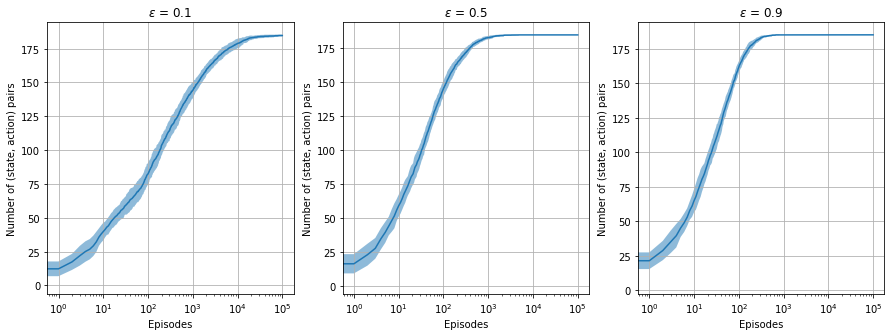

In [5]:
plt.figure(figsize=(15,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes)
    y = np.mean(Qlens[i,:,:],axis=0); ystd = np.std(Qlens[i,:,:],axis=0)

    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
    plt.xscale('log')

    plt.xlabel('Episodes')
    plt.ylabel('Number of (state, action) pairs')
    plt.title('$\epsilon$ = {0}'.format(epsilons[i]))
    plt.grid()
    
plt.savefig('simul4_epsilon_qlens.png',dpi=300)

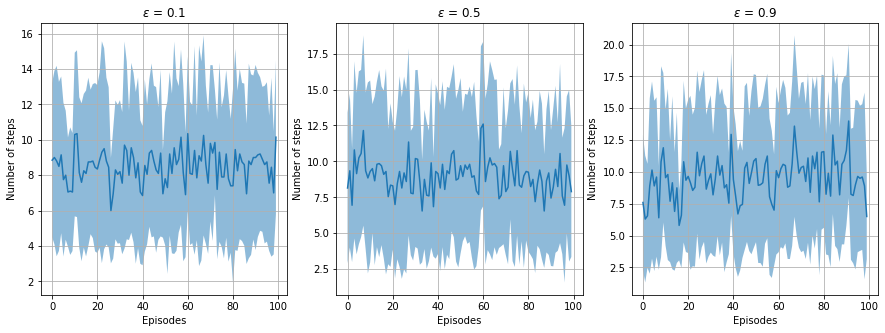

In [6]:
plt.figure(figsize=(15,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes_noexpl)
    y = np.mean(steps_noexpl[i,:,:],axis=0); ystd = np.std(steps_noexpl[i,:,:],axis=0)

    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

    plt.xlabel('Episodes')
    plt.ylabel('Number of steps')
    plt.title('$\epsilon$ = {0}'.format(epsilons[i]))
    plt.grid()
    
plt.savefig('simul4_epsilon_plots.png',dpi=300)